<a href="https://colab.research.google.com/github/he16946/Data_Labs/blob/master/Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spotify Data

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import (cross_validate, cross_val_score, KFold,
                                      train_test_split, StratifiedKFold)
from sklearn.tree import DecisionTreeClassifier,  DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from matplotlib.patches import Patch
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

## Downloading data

In [3]:
os.environ['KAGGLE_USERNAME'] = "ce889group3" # username from the json file

os.environ['KAGGLE_KEY'] = "f0ec34f29bf37cceb765b25f5a1bce2c" # key from the json file

!kaggle datasets download -d geomack/spotifyclassification

  0% 0.00/98.4k [00:00<?, ?B/s]
100% 98.4k/98.4k [00:00<00:00, 30.4MB/s]


In [0]:
! unzip -q "spotifyclassification.zip"

In [0]:
df = pd.read_csv("data.csv")

In [6]:
df.columns

Index(['Unnamed: 0', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target',
       'song_title', 'artist'],
      dtype='object')

In [7]:
print("Total count: ", df['target'].count())

Total count:  2017


In [8]:
print("Liked: ", df['target'].value_counts()[1])
print("Disliked: ", df['target'].value_counts()[0])

Liked:  1020
Disliked:  997


In [9]:
print('Like', round(df['target'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('Dislike', round(df['target'].value_counts()[0]/len(df) * 100,2), '% of the dataset')

Like 50.57 % of the dataset
Dislike 49.43 % of the dataset


## Creating the imbalance

To create the ratio 60 : 40 we reduce the number of disliked songs to 612. 

First the two categories are split:

In [0]:
like = df.loc[df['target'] == 1]
dislike = df.loc[df['target'] == 0]

612 random rows are obtained from the Dislikes

In [0]:
newdis = dislike.sample(n = 612, random_state = 1)

In [0]:
imb = [like, newdis]
imb = pd.concat(imb)

In [13]:
print('Like', round(imb['target'].value_counts()[1]/len(imb) * 100,2), '% of the dataset')
print('Dislike', round(imb['target'].value_counts()[0]/len(imb) * 100,2), '% of the dataset')

Like 62.5 % of the dataset
Dislike 37.5 % of the dataset


## Preprocessing

In [14]:
imb.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


Song title and Artist name columns are removed

In [0]:
imb = imb.drop(['song_title', 'artist', 'Unnamed: 0'], axis = 1)

In [16]:
norm = ((imb - imb.min())/(imb.max()-imb.min()))
norm.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target'],
      dtype='object')

In [17]:
features = list(norm.columns[0:13])
print(features)

['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']


In [0]:
x = norm[features]
y = norm['target']

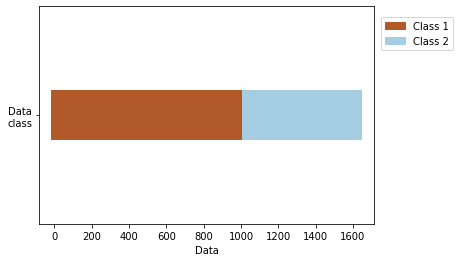

In [19]:
fig, ax = plt.subplots()
cmap = plt.cm.Paired
ax.scatter(range(len(y)),  [3.5] * len(y), c=y, marker='_',
            lw=50, cmap=cmap)
ax.set(yticks=[3.5],
        yticklabels=['Data\nclass'], xlabel="Data")
ax.legend([Patch(color=cmap(12)), Patch(color=cmap(0))],
          ['Class 1', 'Class 2'], loc=(1.02, .8))

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

## Classifieres and Cross Validation

**Dummy Classifier**

In [21]:
dummy = DummyClassifier(strategy='uniform', random_state=1)
dummy.fit(x_train, y_train)
print("Score: ", dummy.score(x_test, y_test))

Score:  0.4877450980392157


**Decision Tree**

In [22]:
dt = DecisionTreeClassifier(min_samples_split = 30, max_depth = 4, random_state = 32)
dt.fit(x_train, y_train)
print("Test score: ", dt.score(x_test, y_test))
print("CrossVal score: ", cross_validate(dt, x_test, y_test, cv = 10)['test_score'].mean())

Test score:  0.75
CrossVal score:  0.7232317073170732


Feature importances 

> Last 5 features have zero importance

Feature ranking:
1. instrumentalness (0.281054)
2. speechiness (0.219130)
3. energy (0.184061)
4. danceability (0.142444)
5. loudness (0.099700)
6. valence (0.048248)
7. tempo (0.025363)
8. time_signature (0.000000)
9. mode (0.000000)
10. liveness (0.000000)
11. key (0.000000)
12. duration_ms (0.000000)
13. acousticness (0.000000)


(0.0, 0.29510703155819556)

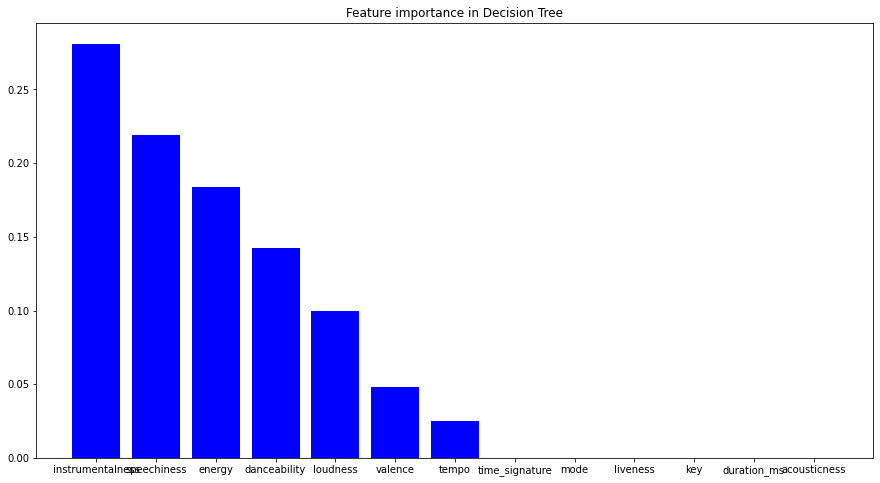

In [23]:
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(x.shape[1]):
  print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]])) 

fig = plt.figure()
plt.title("Feature importance in Decision Tree")
plt.bar(range(x.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(x.shape[1]), np.array(features)[indices])
plt.xlim([-1, x.shape[1]])
fig.set_size_inches(15, 8)
axes = plt.gca()
axes.set_ylim([0, None])

**Random Forest**

In [24]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 4, random_state = 32)
rf.fit(x_train, y_train)
print("Test score: ", rf.score(x_test, y_test))
print("CrossVal score: ", cross_validate(rf, x_test, y_test, cv = 10)['test_score'].mean())

Test score:  0.7524509803921569
CrossVal score:  0.7257317073170731


Feature importances

> All features have non-zero importance

Feature ranking:
1. instrumentalness (0.281054)
2. speechiness (0.219130)
3. energy (0.184061)
4. danceability (0.142444)
5. loudness (0.099700)
6. valence (0.048248)
7. tempo (0.025363)
8. time_signature (0.000000)
9. mode (0.000000)
10. liveness (0.000000)
11. key (0.000000)
12. duration_ms (0.000000)
13. acousticness (0.000000)


(0.0, 0.43422091538404245)

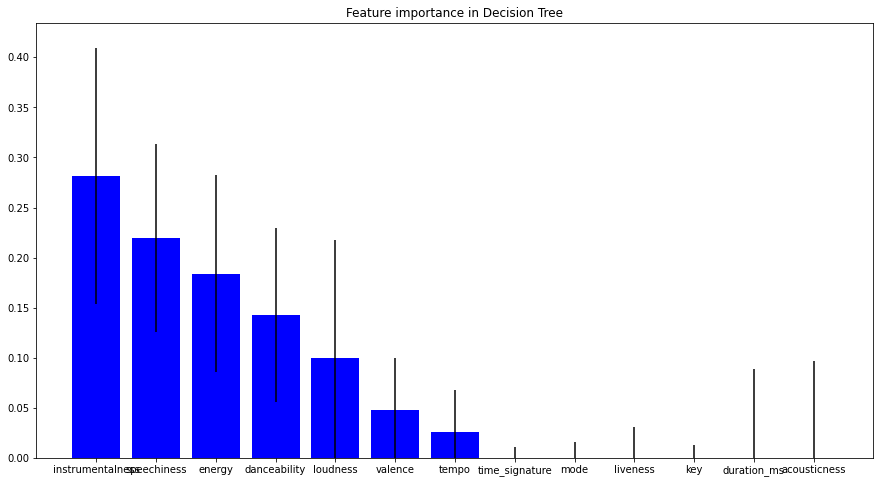

In [25]:
importances = dt.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(x.shape[1]):
  print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]])) 

fig = plt.figure()
plt.title("Feature importance in Decision Tree")
plt.bar(range(x.shape[1]), importances[indices], color="b", yerr=std[indices],align="center")
plt.xticks(range(x.shape[1]), np.array(features)[indices])
plt.xlim([-1, x.shape[1]])
fig.set_size_inches(15, 8)
axes = plt.gca()
axes.set_ylim([0, None])

**Decision Tree Regressor**

In [26]:
tr = DecisionTreeRegressor(random_state = 0, max_depth = 4, min_samples_split= 30)
tr.fit(x_train, y_train)
print("Test score: ", tr.score(x_test, y_test))
print("CrossVal score: ", cross_validate(tr, x_test, y_test, cv = 10)['test_score'].mean())

Test score:  0.2530577326537463
CrossVal score:  0.15319048583352074


**KFold Cross validation**

In [0]:
stnd = StandardScaler()
logit = LogisticRegression()
pipeline = make_pipeline(stnd, logit)
kf = KFold(n_splits = 10)

In [28]:
cv_results = cross_val_score(pipeline, x, y, cv=kf,scoring="accuracy", n_jobs=-1)
cv_results.mean()

0.5555139907227293

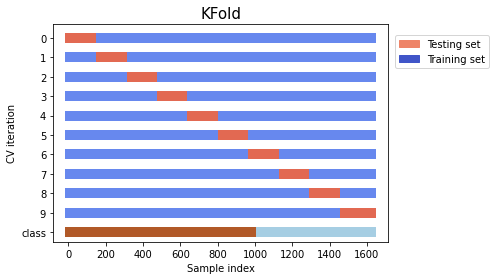

In [29]:
cmap_cv = plt.cm.coolwarm
cmap_data = plt.cm.Paired

def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
        
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)
    
    yticklabels = list(range(n_splits)) + ['class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+1, -.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))

    return ax

fig, ax = plt.subplots()
plot_cv_indices(kf, x, y, ax, 10)

## Split data, Silhouette + Elbow

In [0]:
skf = StratifiedKFold(n_splits=10)

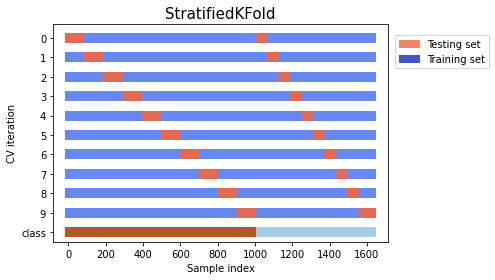

In [31]:
def plot_scv_indices(cv, X, y, ax, n_splits, lw=10):
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    yticklabels = list(range(n_splits)) + ['class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+1, -.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))

    return ax

fig, ax = plt.subplots()
plot_scv_indices(skf, x, y, ax, 10)

Split data into 9/10 and 1/10

In [0]:
i = 0
X = x.values
Y = y.values
for train_index, test_index in skf.split(X, Y):
    if i < 9:
      X_train_9, X_test_9 = X[train_index], X[test_index]
      y_train_9, y_test_9 = Y[train_index], Y[test_index]
      i = i + 1
    else:
      X_train_10 , X_test_10 = X[train_index], X[test_index] 
      y_train_10, y_test_10 = Y[train_index], Y[test_index]

X9 = X_train_9
X9t = X_test_9
Y9 = y_train_9
Y9t = y_test_9

X10 = X_train_10
X10t = X_test_10
Y10 = y_train_10
Y10t = y_test_10

**Silhouette**

For n_clusters = 2 The average silhouette_score is : 0.3310822687795139
For n_clusters = 3 The average silhouette_score is : 0.23189919593631514
For n_clusters = 4 The average silhouette_score is : 0.2420164357844655
For n_clusters = 5 The average silhouette_score is : 0.24441490651830866
For n_clusters = 6 The average silhouette_score is : 0.19997494638428692


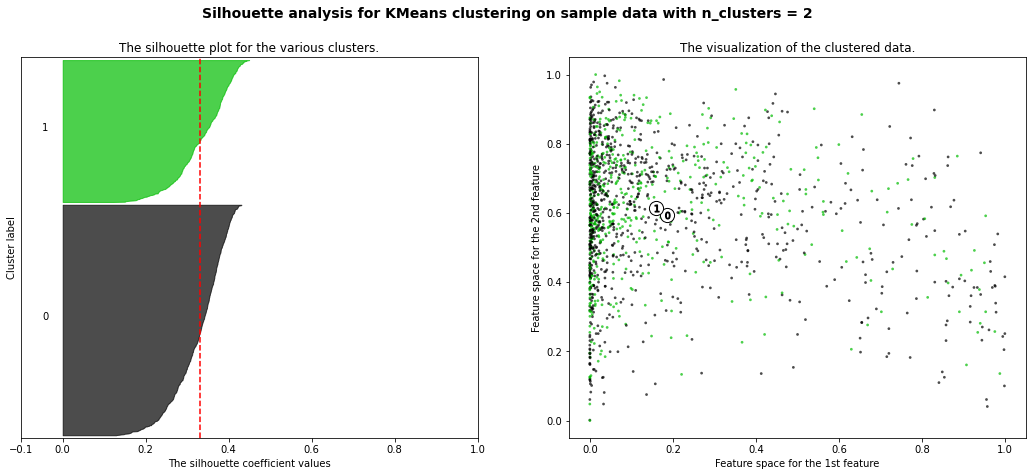

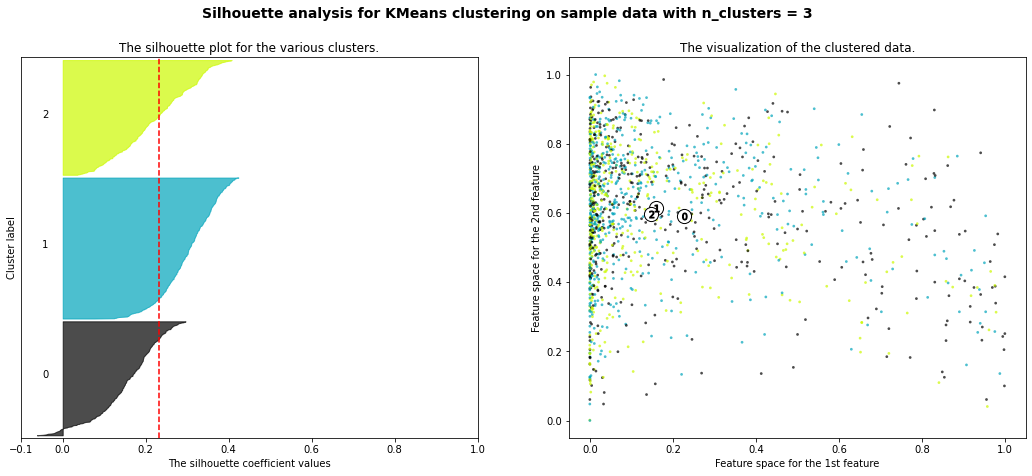

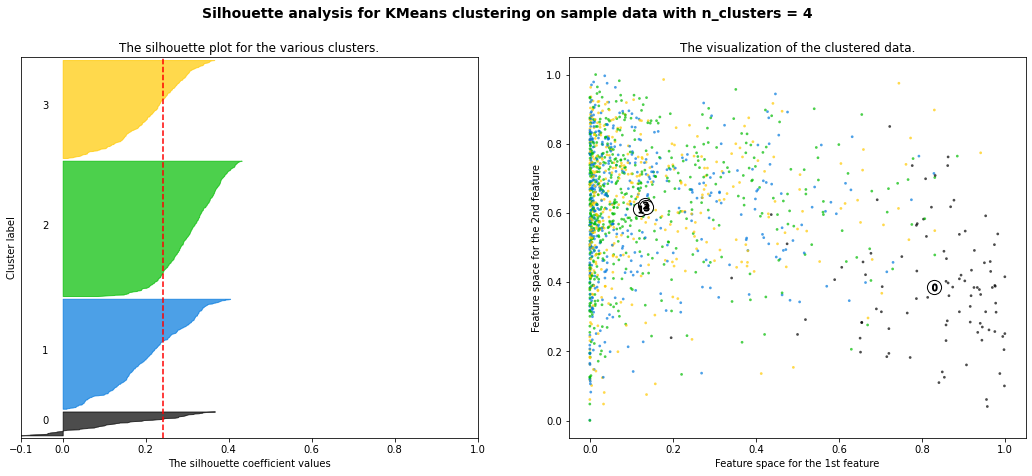

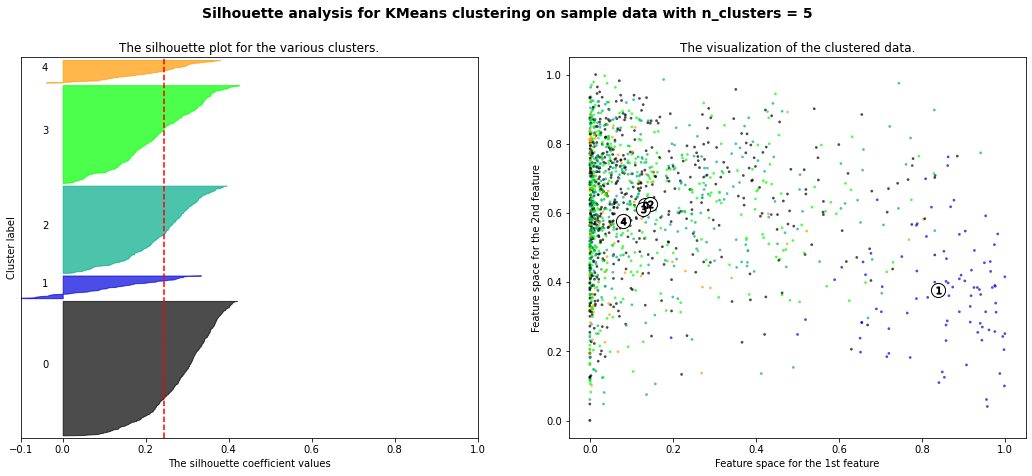

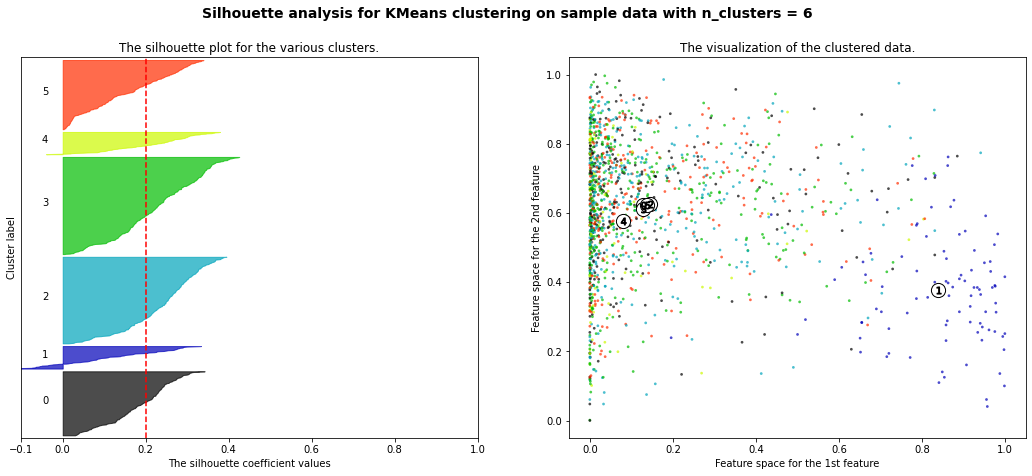

In [33]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X9) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X9)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X9, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X9, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X9[:, 0], X9[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

**Elbow**

In [0]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X9)
    Sum_of_squared_distances.append(km.inertia_)

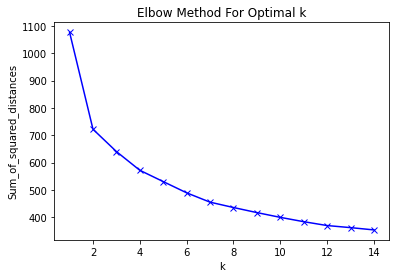

In [35]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## Clustering

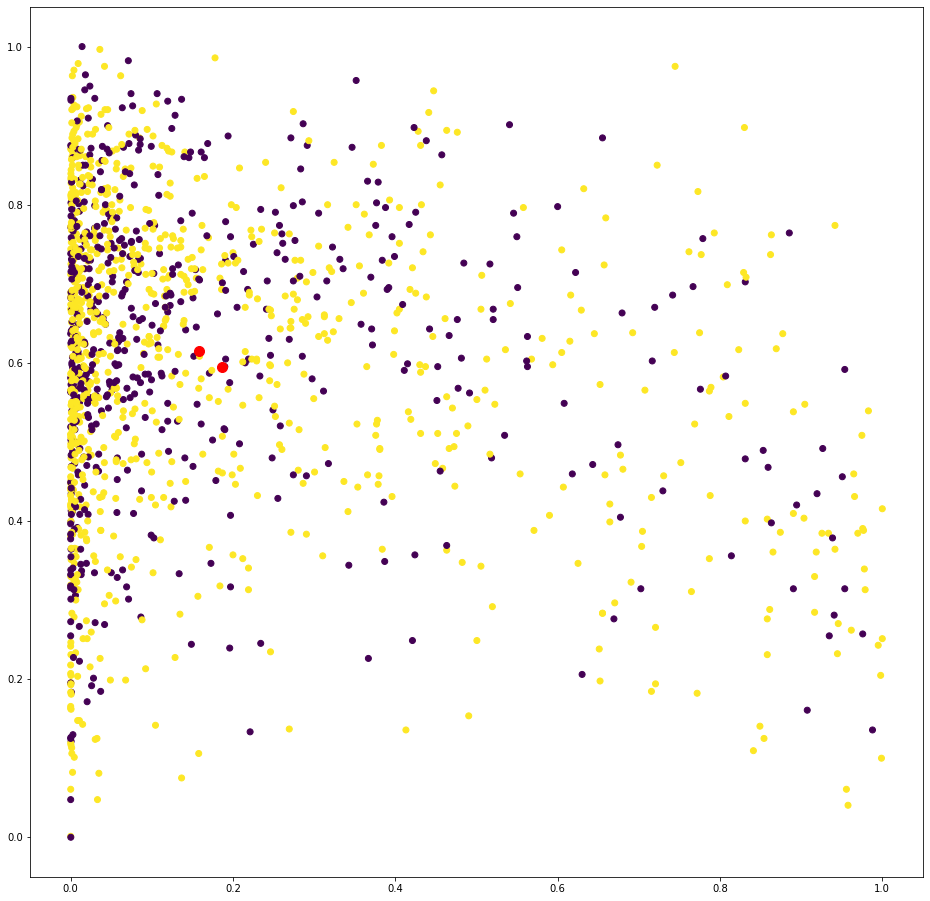

In [36]:
plt.figure(figsize=(16, 16))

km = KMeans(n_clusters=2).fit(X9)
centres = km.cluster_centers_

kmp = km.fit_predict(X9)
plt.scatter(X9[:, 0], X9[:, 1], c=kmp)
plt.scatter(centres[:,0], centres[:,1], c='red', s=100)

plt.show()

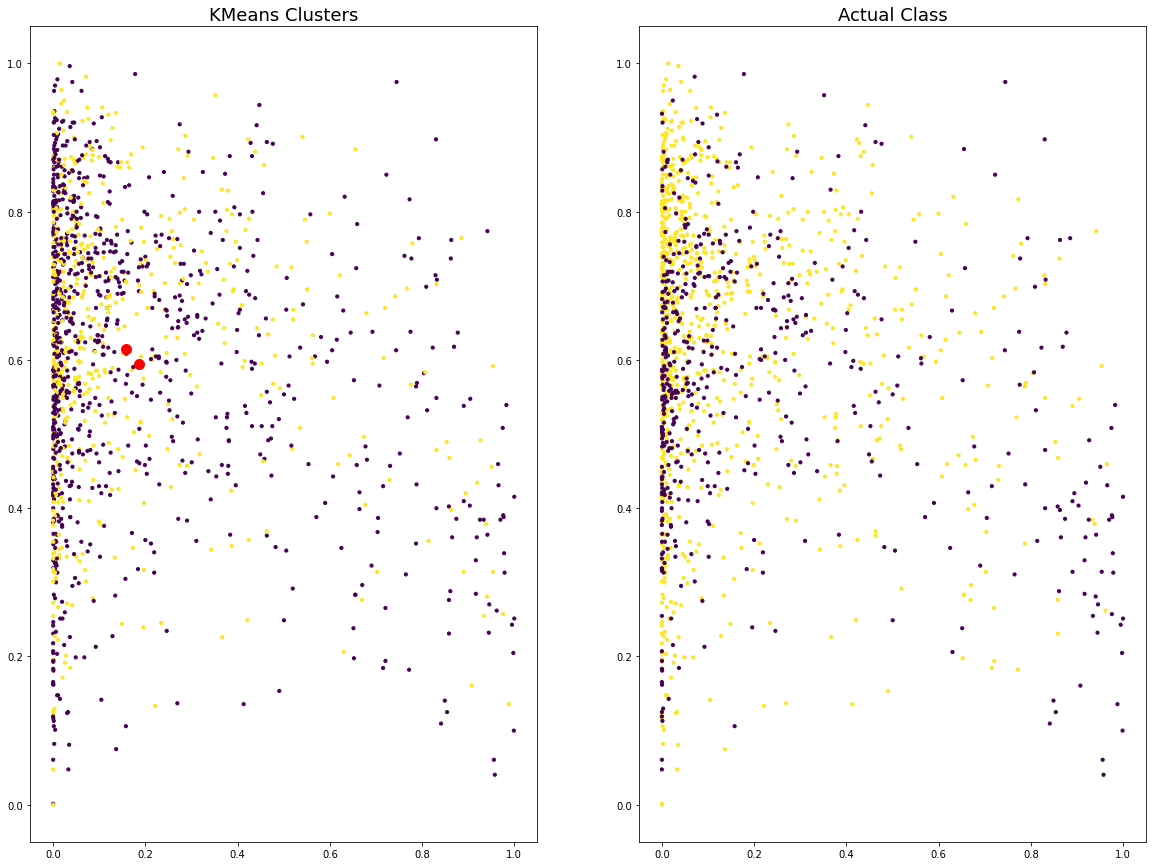

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 15)

km = KMeans(n_clusters=2).fit(X9)
kmp = km.fit_predict(X9)
centres = km.cluster_centers_
labels = km.labels_

ax1.scatter(X9[:, 0], X9[:, 1], c=kmp, s= 10)
ax1.scatter(centres[:,0], centres[:,1], c='red', s=100)
ax1.set_title("KMeans Clusters", fontsize = 18)

ax2.scatter(X9[:, 0], X9[:, 1], c=Y9, alpha = 100, s = 10)
ax2.set_title("Actual Class", fontsize = 18)


fig.show()

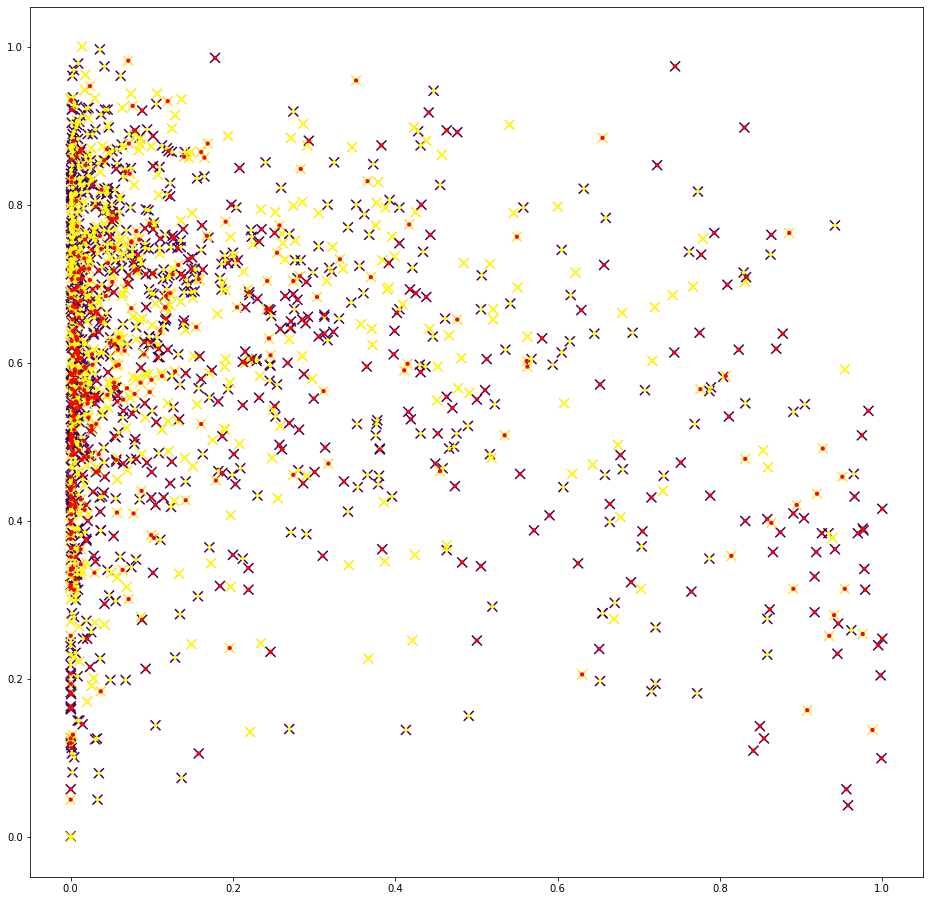

In [38]:
plt.figure(figsize=(16, 16))

plt.scatter(X9[:, 0], X9[:, 1], s = 100, c=labels, marker="x")
plt.scatter(X9[:, 0], X9[:, 1], s = 10, c = Y9, cmap=plt.cm.autumn)

plt.show()

## Random Forest

In [0]:
d = {'class': Y9, 'label':labels}
f = pd.DataFrame(d, dtype=int)
f['correct'] = np.where(f['class'] == f['label'], 'yes', 'no')

In [40]:
unique, counts = np.unique(f['correct'], return_counts=True)
dict(zip(unique, counts))

{'no': 728, 'yes': 741}

In [0]:
cluster_1 = f['label'] == 0
cluster_2 = f['label'] == 1

In [0]:
C1 = f[cluster_1]
C2 = f[cluster_2]

In [43]:
print('Cluster1 is', round(C1['class'].value_counts()[1]/len(C1) * 100,2), "% class 1, ",
      round(C1['class'].value_counts()[0]/len(C1) * 100,2), "% class 2.")
print('Cluster2 is', round(C2['class'].value_counts()[1]/len(C2) * 100,2), "% class 1, ",
      round(C2['class'].value_counts()[0]/len(C2) * 100,2), "% class 2.")

Cluster1 is 59.74 % class 1,  40.26 % class 2.
Cluster2 is 66.96 % class 1,  33.04 % class 2.


In [0]:
d = pd.DataFrame(X9)
d['label']=labels
d['target']=Y9

In [0]:
cluster_1_data = d['label'] == 0
cluster_2_data = d['label'] == 1

In [0]:
C1d = d[cluster_1_data]
C2d = d[cluster_2_data]

In [0]:
C1d = C1d.drop(['label'], axis = 1)
C2d = C2d.drop(['label'], axis = 1)

In [0]:
C1d_target = C1d['target']
C1d = C1d.drop(['target'], axis = 1)

C2d_target = C2d['target']
C2d = C2d.drop(['target'], axis = 1)

In [49]:
rf_cluster1 = RandomForestClassifier(n_estimators = 100, max_depth = 4, random_state = 32)
rf_cluster1.fit(C1d, C1d_target)
print("Test score: ", rf_cluster1.score(X9t, Y9t))
print("CrossVal score: ", cross_validate(rf_cluster1, X9t, Y9t, cv = 10)['test_score'].mean())

Test score:  0.7975460122699386
CrossVal score:  0.7926470588235294


In [50]:
rf_cluster2 = RandomForestClassifier(n_estimators = 100, max_depth = 4, random_state = 32)
rf_cluster2.fit(C2d, C2d_target)
print("Test score: ", rf_cluster2.score(X9t, Y9t))
print("CrossVal score: ", cross_validate(rf_cluster2, X9t, Y9t, cv = 10)['test_score'].mean())

Test score:  0.7668711656441718
CrossVal score:  0.7926470588235294


## X10

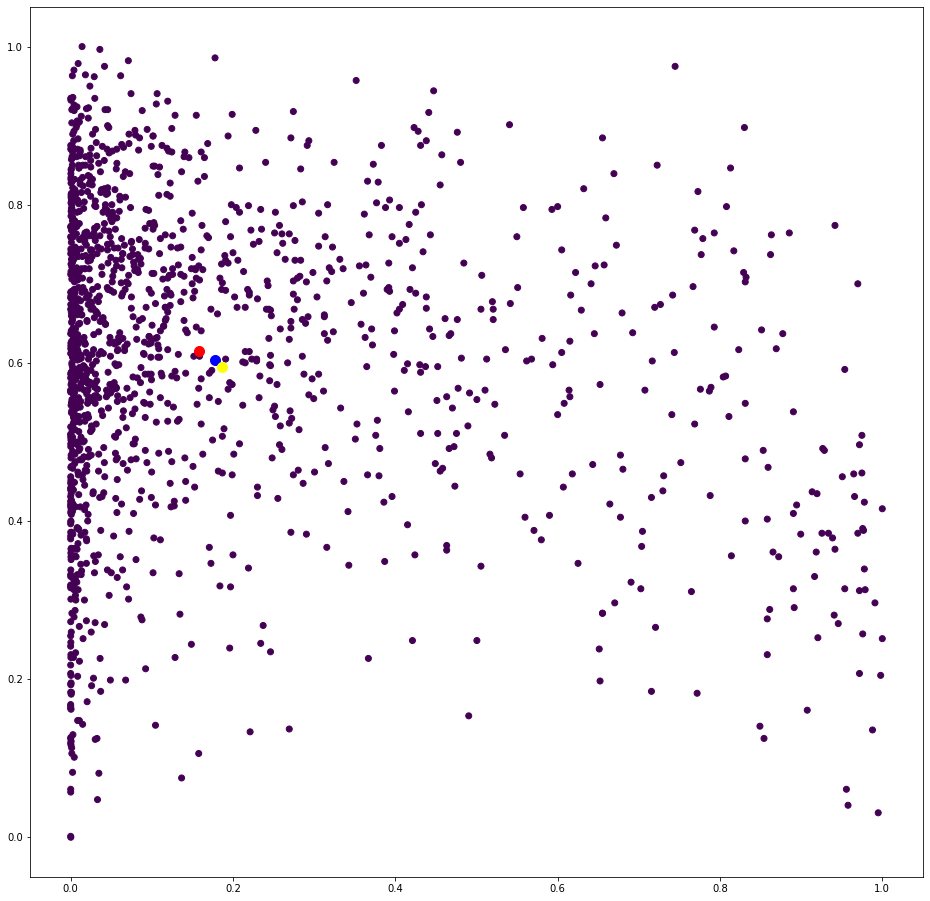

In [103]:
plt.figure(figsize=(16, 16))

km = KMeans(n_clusters=1).fit(X10)
centres_10 = km.cluster_centers_
labels_10 =  km.labels_
kmp = km.fit_predict(X10)

#cluster 1 centre
c1x = centres[0,0]
c1y = centres[0,1]

#cluster 2 centre
c2x = centres[1,0]
c2y = centres[1,1]

plt.scatter(X10[:, 0], X10[:, 1], c=kmp)
plt.scatter(centres_10[:,0], centres_10[:,1], c='blue', s=100)
plt.scatter(c1x, c1y, c='yellow', s=100)
plt.scatter(c2x, c2y, c='red', s=100)

plt.show()

Cluster centre of X10 is closest to cluster 1 (yellow)

In [104]:
print("Test score: ", rf_cluster1.score(X10, Y10))
print("CrossVal score: ", cross_validate(rf_cluster1, X10, Y10, cv = 10)['test_score'].mean())

Test score:  0.7760381211708646
CrossVal score:  0.7474932438728916


In [105]:
print("Test score: ", rf_cluster1.score(X10t, Y10t))
print("CrossVal score: ", cross_validate(rf_cluster1, X10t, Y10t, cv = 10)['test_score'].mean())

Test score:  0.8282208588957055
CrossVal score:  0.7191176470588235
